# ETL Pipeline Preparation
In this notebook, the dataset is prepared by combining two csv files, cleaning up duplicates and the categories that are used as labels in the machine learning model. The clean dataset is then saved into an SQL database.

## 1. Import libraries and load datasets.

In [1]:
# import libraries
import pandas as pd
import numpy as np

from sqlalchemy.engine import create_engine


In [2]:
# load messages dataset
messages = pd.read_csv("data/messages.csv")
messages.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [3]:
messages.shape

(26248, 4)

### The messages dataset contains text data in both English and their original languages and the method it was sent (genre). Each message is assigned to one id.

In [4]:
# load categories dataset
categories = pd.read_csv("data/categories.csv")
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


### The caterogies dataset has the same id number as messages with a category column including different values that need to be separated. Categories are what we want to predict so they will be the labels of the machine learning model.

## 2. Merge datasets


In [5]:
# merge datasets
df = messages.merge(categories, on="id")
df.head()

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,related-1;request-0;offer-0;aid_related-0;medi...
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,related-1;request-1;offer-0;aid_related-1;medi...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,related-1;request-0;offer-0;aid_related-0;medi...


## 3. Split `categories` into separate category columns.


The category names are in the value cells so they need to be extracted from them and then assigned as column names.


In [6]:
# create a dataframe of the 36 individual category columns
categories = df['categories'].str.split(';',expand=True)


In [7]:
# select the first row of the categories dataframe
row = categories.iloc[0]

In [8]:
# use this row to extract a list of new column names for categories.
# one way is to apply a lambda function that takes everything 
# up to the second to last character of each string with slicing
category_colnames = row.apply(lambda x: x[:-2])
print(category_colnames)

0                    related
1                    request
2                      offer
3                aid_related
4               medical_help
5           medical_products
6          search_and_rescue
7                   security
8                   military
9                child_alone
10                     water
11                      food
12                   shelter
13                  clothing
14                     money
15            missing_people
16                  refugees
17                     death
18                 other_aid
19    infrastructure_related
20                 transport
21                 buildings
22               electricity
23                     tools
24                 hospitals
25                     shops
26               aid_centers
27      other_infrastructure
28           weather_related
29                    floods
30                     storm
31                      fire
32                earthquake
33                      cold
34            

In [9]:
# rename the columns of `categories`
categories.columns = category_colnames


### 4. Convert category values to just numbers 0 or 1.


After extracting the column names, we need to extract the values and put them back in each column.

In [10]:
for column in categories:
    # set each value to be the last character of the string
    categories[column] = categories[column].str[-1:]
    # convert column from string to numeric
    categories[column] = categories[column].astype(int) #instructions say we have to convert them to float but I changed to integer since these are categories rathers than quantitative.
    
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
categories.describe()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26386.000000,26386.000000,26386.000000,26386.000000,26386.00000,26386.000000,26386.000000,26386.00000,26386.000000,26386.0,...,26386.000000,26386.000000,26386.000000,26386.000000,26386.000000,26386.000000,26386.000000,26386.000000,26386.000000,26386.000000
mean,0.775032,0.171038,0.004586,0.415144,0.07955,0.049989,0.027477,0.01785,0.032707,0.0,...,0.011711,0.043773,0.278292,0.082506,0.093383,0.010687,0.093269,0.020200,0.052263,0.193777
std,0.435692,0.376549,0.067564,0.492756,0.27060,0.217926,0.163471,0.13241,0.177871,0.0,...,0.107583,0.204594,0.448166,0.275139,0.290974,0.102828,0.290815,0.140687,0.222560,0.395264
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We see that the category related has 0, 1 and 2. Let's plot related.


<Axes: >

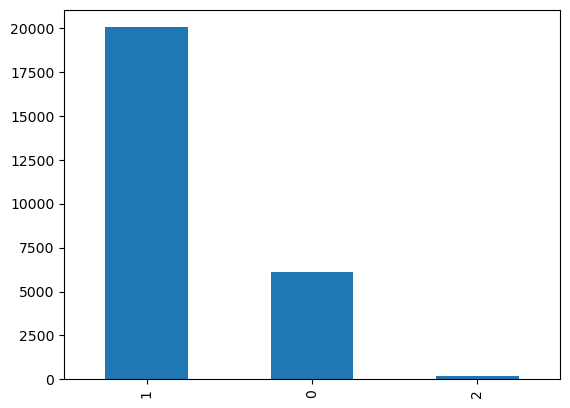

In [26]:
categories['related'].value_counts().plot(kind='bar')

In [27]:
categories['related'].value_counts()

1    20042
0     6140
2      204
Name: related, dtype: int64

204 rows have 2 in the related category. Let's drop all the rows with 2 as category after we merged the categories with the messages.

### 5. Replace `categories` column in `df` with new category columns.
From the merge dataframe, we now can drop the categories column and add the new separated categories from above.

In [32]:
df=df.drop(columns=['categories'], axis=1)

df.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [33]:
# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df,categories],axis=1)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Dropping rows with related including value 2.


In [35]:
df.shape

(26386, 40)

In [42]:
df = df[df['related'] != 2]

(26182, 40)

## 6. Remove duplicates.
Finally, let's check for duplicates and remove them if they exist.

In [43]:
# check number of duplicates
df.duplicated(keep='last').sum()

154

It looks like we have 154 duplicated rows.

In [44]:
# drop duplicates
df1=df.drop_duplicates()
df1.shape

(26028, 40)

In [45]:
# check number of duplicates again after dropping them
df.shape[0]-df1.shape[0]

154

In [46]:
df=df.drop_duplicates()

df is all cleaned up and ready to be used for the next steps.

## 7. Save the clean dataset into an sqlite database.

Let's save our df into a SQLite database using the SQLAlchemy library.

In [48]:
engine = create_engine('sqlite:///data/DisasterResponse.db')
df.to_sql('data', engine, index=False, if_exists='replace')

26028

## You can find this code ready to run in /data/process_data.py